# Canonical (NVT) ensemble

## TL;DR

- NVT-MD simulations assume constant temperature and volume. This ensemble should be chosen when one wants to ignore volume and temperature changes.
- Applications include ion diffusion in solids, adsorption and reaction on slab-structured surfaces, and adsorption and reaction on clusters.
- There are several variations of heat baths in NVT-MD simulation methods to control temperature, such as the Berendsen, Langevin, and Nosé-Hoover heat baths. They are also implemented in ASE.
- The Berendsen heat bath method is simple and has good convergence, but it changes the velocity distribution of atoms in the entire system uniformly, which can result in unnatural phenomena.
- The Langevin heat bath method controls temperature by applying random forces to individual atoms, which are appropriately sampled using a statistical method. Since each atom is controlled individually, even mixed phases can be handled properly. It is not suitable for precise trajectory analysis because it does not reproduce the same trajectories even after repeated calculations due to its statistical nature.
- The Nosé-Hoover heat bath method is one of the most universally used temperature control methods. In principle, it reproduces the correct NVT ensemble, but there are exceptions for special systems.

In the previous section, we learned about MD simulation in the NVE ensemble, the simplest form of MD simulation.

We will now discuss MD simulations for one of the most commonly used state distributions, [canonical ensemble](https://en.wikipedia.org/wiki/Canonical_ensemble) (NVT ensemble). 
The canonical ensemble is a statistical mechanical state distribution where the number of particles (N), volume (V), and temperature (T) are constant. 
It is applied when the volume change is negligible for the target system. 
A good example would be a simulation in a relatively low temperature region where the volume expansion is negligible.

Let's take a look at some typical methods through some specific examples.

## Calculation example 1: Melting of fcc-Al

As a first example, let's look at the simulation for the melting state of metallic aluminum treated in section 6-1.

In section 6-1, the simulation was performed at a high initial temperature of 1600 K to ensure that the metallic aluminum appears sufficiently molten. 
However, **this time we will run the simulation with an initial temperature of 1000 K**, and the NVE ensemble is the same as in the previous section, only the temperature is set to 1000 K. The results are shown below.

<br>
<figure style="text-align:center">
  <img src="../assets/ch6/Fig6-2_fcc-Al_NVE_1000Kstart.png" alt="fcc-Al_NVE_1000Kstart">
  <figcaption>Fig6-2a. Fcc-Al in NVE ensemble starting at 1000 K</figcaption>
  <figcaption>(File: ../input/ch6/6-2_fcc-Al_NVE_1000Kstart.traj)</figcaption>
</figure>

Although the lattice is indeed much perturbed, the original FCC crystal structure is clearly visible. The melting point of real Al metal is 933 K, but an initial temperature of 1000 K seems insufficient to melt the system. 

We will then run the NVT ensemble at the set temperature of 1000 K. The calculation method is as follows. The calculation time is almost the same as the first NVE ensemble calculation.

In [1]:
import os
from asap3 import EMT
calculator = EMT()

import ase
from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.nvtberendsen import NVTBerendsen
from ase.md import MDLogger
from ase import units
from time import perf_counter

# Set up a crystal
atoms = bulk("Al","fcc",a=4.3,cubic=True)
atoms.pbc = True
atoms *= 3
print("atoms = ",atoms)

# input parameters
time_step    = 1.0    # fsec
temperature  = 1000    # Kelvin
num_md_steps = 1000000 
num_interval = 10000
taut         = 1.0    # fs
    
atoms.calc = calculator
    
print(f"taut = {taut:.3f}")

output_filename = "./output/ch6/fcc-Al_NVT-Berendsen_1000K"
print("output_filename = ",output_filename)

log_filename = output_filename + ".log"
print("log_filename = ",log_filename)
traj_filename = output_filename + ".traj"
print("traj_filename = ",traj_filename)


# Set the momenta corresponding to the given "temperature"
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
Stationary(atoms)  # Set zero total momentum to avoid drifting

# run MD
dyn = NVTBerendsen(atoms, time_step*units.fs, temperature_K = temperature, taut=taut*units.fs, loginterval=num_interval, trajectory=traj_filename)

# Print statements
def print_dyn():
    imd = dyn.get_number_of_steps()
    etot  = atoms.get_total_energy()
    temp_K = atoms.get_temperature()
    stress = atoms.get_stress(include_ideal_gas=True)/units.GPa
    stress_ave = (stress[0]+stress[1]+stress[2])/3.0 
    elapsed_time = perf_counter() - start_time
    print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {stress_ave:.2f}  {stress[0]:.2f}  {stress[1]:.2f}  {stress[2]:.2f}  {stress[3]:.2f}  {stress[4]:.2f}  {stress[5]:.2f}    {elapsed_time:.3f}")


dyn.attach(print_dyn, interval=num_interval)
dyn.attach(MDLogger(dyn, atoms, output_filename+".log", header=True, stress=True, peratom=True, mode="a"), interval=num_interval)

# Now run the dynamics
start_time = perf_counter()
print(f"    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)")
dyn.run(num_md_steps)

atoms =  Atoms(symbols='Al108', pbc=True, cell=[12.899999999999999, 12.899999999999999, 12.899999999999999])
taut = 1.000
output_filename =  ./output/ch6/fcc-Al_NVT-Berendsen_1000K
log_filename =  ./output/ch6/fcc-Al_NVT-Berendsen_1000K.log
traj_filename =  ./output/ch6/fcc-Al_NVT-Berendsen_1000K.traj
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)
    0   23.764    1000.00    7.17  7.19  7.18  7.14  -0.03  0.10  -0.04    0.002
  10000   45.661    997.10    0.06  -0.03  0.23  -0.00  0.49  0.11  -0.68    6.141
  20000   40.488    1001.20    1.28  0.95  1.39  1.49  0.07  0.31  -0.22    12.240
  30000   42.446    999.51    0.91  0.35  1.33  1.06  -0.07  0.11  0.36    19.200
  40000   44.621    1000.50    0.39  0.66  -0.03  0.55  0.69  0.27  0.51    28.047
  50000   41.777    1002.44    1.03  1.36  1.23  0.49  0.02  -0.12  0.16    37.952
  60000   43.185    1001.37    0.70  0.61  0.86  0.62  -0.45  0.17  0.24    46.973
  70000   42.578    1005.13    0

True

In this case, we are using a method called the **Berendsen heat bath method**. 
In this method, the temperature is adjusted by scaling the velocity of the atoms so that they approach the target temperature [1-3].

Specifically, as explained in section 6-1, the relationship between temperature and velocity is given by

$$K = \sum_{i=1}^{N} \frac{1}{2} m_i {\mathbf{v}}_i^2 = \frac{3}{2} k_B T$$

To control the temperature, the velocity of the atoms in the entire system is scaled and controlled. 

The coefficient that scales the velocity is scaled is given by the following equation

$$
\lambda = \sqrt{1+\frac{\Delta t}{\tau_T}\left(\frac{T_0}{T(t)}-1\right)}
$$

where $\Delta t$ is the time step and $\tau_T$ is the time constant of the heat bath. 
This method can reach the target temperature more gradually by controlling the time constant $\tau$. 
When $\tau_T=\Delta t$, it is identical to the simplest temperature control method, the so-called rate scaling method. (i.e. $\lambda = \sqrt{T_0/T(t)}$) 
In this case, the temperature is always a given temperature and the temperature constraint is considered to be maximized. 
Conversely, as $\tau$ increases, the temperature control becomes weaker and it takes longer to reach the target temperature. 
Considering the actual state of matter, a certain amount of relaxation time should be necessary, and for practical use, it is common to set the relaxation time to be sufficiently short compared to the MD calculation time. 

In this method, the temperature of the system is corrected to decay exponentially as follows.

$$
\frac{dT}{dt} = \frac{T_0-T}{\tau_T}
$$

Now let's look at the results of the NVT-MD simulation above.

In [2]:
from ase.io import Trajectory
from pfcc_extras.visualize.povray import traj_to_apng
from IPython.display import Image


traj = Trajectory(traj_filename)
traj_to_apng(traj, f"output/ch6/Fig6-2_fcc-Al_NVT-Berendsen_1000K_unwrap.png", rotation="0x,0y,0z", clean=True, n_jobs=16)

Image(url="output/ch6/Fig6-2_fcc-Al_NVT-Berendsen_1000K_unwrap.png")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    6.1s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:   12.5s finished


In [3]:
# Please remove comment out if you want to show trajectory in nglviewer.

from pfcc_extras.visualize.view import view_ngl
# view_ngl(traj)

<br>
<figure style="text-align:center">
  <img src="../assets/ch6/Fig6-2_fcc-Al_NVT-Berendsen_1000K.png" alt="fcc-Al_NVE_1000Kstart">
  <figcaption>Fig6-2b. Fcc-Al in NVT ensemble using Berendsen thermostat at 1000 K</figcaption>
  <figcaption>(File: ../input/ch6/6-2_fcc-Al_NVT-Berendsen_1000K.traj")</figcaption>
</figure>

In contrast to the previous NVE calculation, the structure is very dynamic and its behavior is complex. The structure is in a randomly arranged melt state. 
This is because the temperature is always controlled and kept around 1000 K in NVT ensemble calculations, which is always above the melting point. 
(Note: The actual ASE results show that the atoms diffuse violently and spread outward from the cell. For display purposes, the above figure uses the `wrap` method to draw the atoms back inside the cell.)

The following plots show the time evolution of the total energy (Tot.E), potential energy (PE), kinetic energy (KE), and temperature (Temp.) of the entire system when calculated with the NVE and NVT ensembles. By definition, 
the total energy remains constant for the NVE ensemble, and the temperature is nealy fixed for the NVT ensemble. 
In the Berendsen heat bath method, which is a king of NVT methods, the total energy fluctuates, but the kinetic energy and temperature stay nearly constant. (Actually, there are small fluctuations, but they are too small to be seen due to the scale of the graph.)

<p class="aligncenter">
<div>
    <figure style="text-align: center">
        <img src="../assets/ch6/Fig6-2_fcc-Al_NVE-VelocityVerlet_1000K.png"/>
        <img src="../assets/ch6/Fig6-2_fcc-Al_NVT-Berendsen_1000K_E_vs_t.png"/>
        <figcaption align = "center">Fig.6-2c. Comparison of energies and temperatures between NVE (top) and NVT (bottom) calculations.</figcaption>
    </figure>
</div>
</p>
</br>

The above plot regarding NVT can be prepared as follows. See previous section regarding NVE.

In [4]:
import pandas as pd

df = pd.read_csv(
    log_filename,
    delim_whitespace=True,
    names=["Time[ps]", "Etot/N[eV]", "Epot/N[eV]", "Ekin/N[eV]", "T[K]",
           "stressxx", "stressyy", "stresszz", "stressyz", "stressxz", "stressxy"],
    skiprows=1,
    header=None,
)
df

/tmp/ipykernel_49628/2151791511.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K],stressxx,stressyy,stresszz,stressyz,stressxz,stressxy
0,0.0,0.2200,0.0908,0.1293,1000.0,7.194,7.179,7.141,-0.029,0.101,-0.042
1,10.0,0.4228,0.2939,0.1289,997.1,-0.032,0.225,-0.002,0.492,0.109,-0.681
2,20.0,0.3749,0.2455,0.1294,1001.2,0.949,1.388,1.489,0.070,0.313,-0.224
3,30.0,0.3930,0.2638,0.1292,999.5,0.347,1.332,1.060,-0.073,0.114,0.362
4,40.0,0.4132,0.2838,0.1293,1000.5,0.657,-0.031,0.554,0.694,0.271,0.509
...,...,...,...,...,...,...,...,...,...,...,...
96,960.0,0.4084,0.2792,0.1292,999.3,0.537,0.401,0.261,0.221,-0.302,-0.541
97,970.0,0.3893,0.2606,0.1287,995.8,1.312,1.070,0.456,-0.212,0.069,0.466
98,980.0,0.3738,0.2449,0.1289,997.0,1.651,0.947,1.314,0.232,-0.487,0.365
99,990.0,0.4017,0.2733,0.1284,993.2,0.720,0.889,-0.099,-0.540,-0.122,-0.110


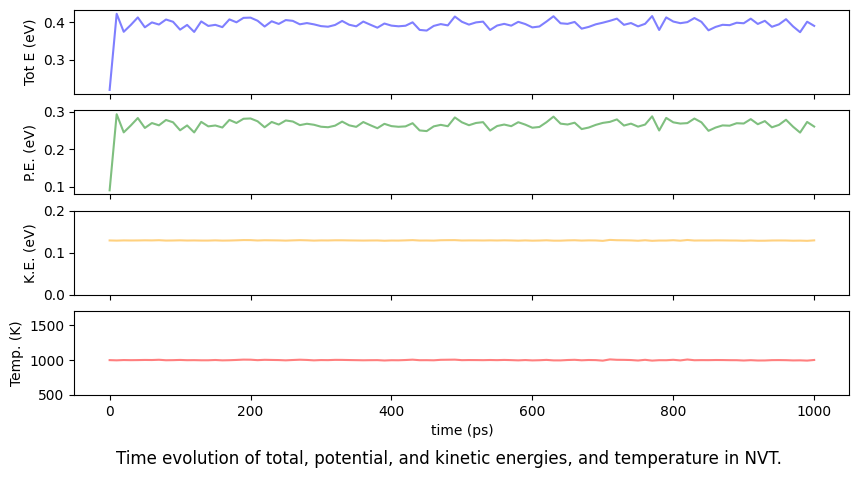

In [5]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])  # x axis label
ax1.set_ylabel('Tot E (eV)')  # y axis label
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])  # x axis label
ax2.set_ylabel('P.E. (eV)')  # y axis label
ax2.plot(df["Time[ps]"], df["Epot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])  # x axis label
ax3.set_ylabel('K.E. (eV)')  # y axis label
ax3.set_ylim([0.0, 0.2])
ax3.plot(df["Time[ps]"], df["Ekin/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')  # x axis label
ax4.set_ylabel('Temp. (K)')  # y axis label
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([500., 1700])

fig.suptitle("Time evolution of total, potential, and kinetic energies, and temperature in NVT.", y=0)

#plt.savefig("Fig6-2_fcc-Al_NVT-Berendsen_1000K_E_vs_t.png")  # <- Use if saving to an image file is desired
plt.show()

A note on calculations using the Berendsen heat bath method.

1. Setting the appropriate time constant.
The Berendsen heat bath method has a time constant $\tau$ as a temperature control parameter. This $\tau$ is a parameter that determines the relaxation time to reach the target temperature. The smaller $\tau$ is, the faster the convergence speed is. If $\tau$ is too small, the calculation becomes unstable and the temperature value shows unnatural behavior. In general, $\tau$ should be **several to five times of the time step** of the MD simulation. The following graph shows the behavior of the overall system temperature when the time constant $\tau$ is varied for the above fcc-Al system, see Fig. 6-2d. As mentioned above, when $\tau$ is 0.2 fs, the system exhibits very unstable behavior, with large temperature transitions up and down, and the system is unable to maintain equilibrium. For $\tau$ of 1 or 2 fs, the temperature is quite tightly controlled, and for $\tau$ of 5 to 10 fs, the temperature is loosely controlled, and the fluctuations are relatively large but in a more realistic range.

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_fcc-Al_NVT-Berendsen_1000K_taut.png"/>
    <figcaption align = "center">Fig.6-2d. Temperature evolution with various time constant $\tau$.</figcaption>
</figure>
</br>

2. The case when the system converges to unrealistic state.
The Berendsen dynamic is a velocity scaling method, in which the velocity of all atoms in the calculation is changed uniformly. By moving the entire velocity distribution, the temperature of the entire system is brought into alignment with the target temperature, but this operation itself is very artificial and differs from a thermodynamically correct canonical (NVT) ensemble. The major problem of this method is that it creates unrealistic states when applied to systems in which several substances with very different behaviors coexist. For example, if one wants to use NVT to calculate the interface between a solid and a liquid, Berendsen heat bath method might result in an unnatural situation where one will be at a high temperature and the other at a low temperature, and the total temperature will be at the target temperature. (A specific example is explained at the end of this section.)

If you are careful about the above points and do not require strictly correct thermodynamic distributions, the Berendsen heat bath method is a very convenient calculation method because it converges to an equilibrium state quickly and is simple and easy to understand in principle. 
For example, if you simply want to create a state with thermal fluctuation, this is a very effective calculation method.

## Calculation example 2: Ion diffusion in solids

Let us consider ion diffusion in solid electrolytes as the next calculation example of the NVT ensemble.

Li$_{10}$GeP$_{2}$S$_{12}$ (LGPS) is one of the materials that have attracted significant attention in recent years as a solid electrolyte for all-solid-state batteries. It is characterized by very high ionic conductivity (12 mS/cm @ 298 K) comparable to that of liquid electrolytes. The crystal structure is as follows (The reference structure is [from Li10Ge(PS6)2_mp-696138_computed](https://materialsproject.org/materials/mp-696138/) in [Materials Project](https://materialsproject.org/). The structure shown below is based on that structure and optimized with PFP).

Input cif file is modified from  
A. Jain*, S.P. Ong*, G. Hautier, W. Chen, W.D. Richards, S. Dacek, S. Cholia, D. Gunter, D. Skinner, G. Ceder, K.A. Persson (*=equal contributions)  
The Materials Project: A materials genome approach to accelerating materials innovation
APL Materials, 2013, 1(1), 011002.  
[doi:10.1063/1.4812323](http://dx.doi.org/10.1063/1.4812323)  
[[bibtex]](https://materialsproject.org/static/docs/jain_ong2013.349ca3156250.bib)  
Licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)  

In [6]:
atoms = ase.io.read("../input/ch6/LGPS_2x2x1_pfp-opt.cif")

view_ngl(atoms, representations=["ball+stick"])

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_LGPS_2x2x1_pfp-opt.png" width="360">
    <figcaption align = "center">Fig.6-2e. Crystal structure of Li$_{10}$GeP$_2$S$_{12}$.</figcaption>
</figure>
</br>

For convenience of calculation, unit cell is expanded to 2x2x1. This is because we expect that increasing the number of Li ions will reduce the statistical error. Although the calculation time may increase slightly, there is no significant problem in practice, because the extended structure has only about 200 atoms in total.
We would like to determine the Li ion diffusion coefficient within this material using MD simulations. Since the composition of this material is complex and there is no general classical force field available, we will use the PFP implemented in [Matlantis](https://matlantis.com/). (It is possible that a general-purpose force field could exist if we do a more thorough search of academic papers, but since it was not immediately found and even if it were found, the difficulty of implementation is unknown, the time, effort, and accuracy involved in these processes make the use of a general-purpose machine-learning potential a major advantage.)

The script for running this NVT-MD simulation is shown below. The following is a test calculation with 10 MD steps. 
In the actual calculation for computing diffusivity, 10^6 steps calculation is performed at 1 fs/step and 1 ns MD simulation is performed.

In [7]:
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
estimator = Estimator(model_version="v2.0.0",calc_mode=EstimatorCalcMode.CRYSTAL_U0)
calculator = ASECalculator(estimator)

import ase
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase.md import MDLogger
from ase import units
from time import perf_counter

# Set up a crystal
atoms = ase.io.read("../input/ch6/LGPS_2x2x1_pfp-opt.cif")
atoms.pbc=True
print("atoms = ",atoms)
atoms.calc = calculator

# input parameters
time_step    = 1.0    # fsec
temperature  = 773    # Kelvin
num_md_steps = 10     # Total MD step, for testing.
# num_md_steps = 1e6    # Total MD step, for actual run.
num_interval = 1      # Output printing interval
friction_coeff = 0.002
print(f"friction_coeff = {friction_coeff:.3f}")

# Define output filenames
output_filename = "./output/ch6/Li10Ge(PS6)2_mp-696138_Langevin_773K"
print("output_filename = ",output_filename)
log_filename = output_filename + ".log"
print("log_filename = ",log_filename)
traj_filename = output_filename + ".traj"
print("traj_filename = ",traj_filename)

# run MD
dyn = Langevin(atoms, time_step*units.fs, friction=friction_coeff, temperature_K=temperature, loginterval=num_interval, trajectory=traj_filename)
    
# Print statements
def print_dyn():
    imd = dyn.get_number_of_steps()
    etot  = atoms.get_total_energy()
    temp_K = atoms.get_temperature()
    stress = atoms.get_stress(include_ideal_gas=True)/units.GPa
    stress_ave = (stress[0]+stress[1]+stress[2])/3.0 
    elapsed_time = perf_counter() - start_time
    print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {stress_ave:.2f}  {stress[0]:.2f}  {stress[1]:.2f}  {stress[2]:.2f}  {stress[3]:.2f}  {stress[4]:.2f}  {stress[5]:.2f}    {elapsed_time:.3f}")


dyn.attach(print_dyn, interval=num_interval)
dyn.attach(MDLogger(dyn, atoms, log_filename, header=True, stress=True, peratom=True, mode="w"), interval=num_interval)

# Now run the dynamics
start_time = perf_counter()
print(f"    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)")
dyn.run(num_md_steps)

atoms =  Atoms(symbols='Ge8Li80P16S96', pbc=True, cell=[[17.2189, 0.0, 0.0], [-0.07190443131522067, 17.742454297891182, 0.0], [-0.13259731631828015, -0.4464045597143071, 13.005365377826626]], spacegroup_kinds=...)
friction_coeff = 0.002
output_filename =  ./output/ch6/Li10Ge(PS6)2_mp-696138_Langevin_773K
log_filename =  ./output/ch6/Li10Ge(PS6)2_mp-696138_Langevin_773K.log
traj_filename =  ./output/ch6/Li10Ge(PS6)2_mp-696138_Langevin_773K.traj
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)
    0   -699.887    0.00    0.00  0.00  0.00  0.00  -0.00  -0.00  0.00    0.045
    1   -699.879    0.32    0.00  0.00  0.00  0.00  -0.00  -0.00  0.00    0.105
    2   -699.871    0.65    0.00  0.00  0.00  0.00  -0.00  -0.00  -0.00    0.164
    3   -699.862    0.98    -0.00  -0.00  0.00  -0.00  -0.00  -0.00  -0.00    0.229
    4   -699.854    1.31    -0.00  -0.00  -0.00  -0.00  -0.00  -0.00  -0.00    0.313
    5   -699.842    1.76    -0.00  -0.00  -0.00  -0.01 

True

When MD is performed in the time of actual (non-test) calculation, the following figure is obtained with trajectory visualization.
You can see that the purple Li ions are moving (diffusing) significantly.
Although it is shown as if it is going to an empty space, Ge, P, and S actually exist outside the unit cell due to the periodic boundary condition.

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_LGPS_2x2x1_Langevin_773K.png"/>
    <figcaption align = "center">Li$_{10}$GeP$_{2}$S$_{12}$ crystal at 773 K.</figcaption>
</figure>
</br>

Here, we have performed NVT-MD simulations using the **Langevin heat bath method**. 
This method is a statistical approach that controls the temperature by applying a force on each atom that follows a certain probability distribution, often called a random force [1,4].

Specifically, the equation of motion for Langevin heat bath method can be written in the following form

$$
m_i\ddot{\mathbf{x}_i}(t)=\mathbf{F}(\mathbf{x}_i(t)) -\gamma m_i\dot{\mathbf{x}_i}(t)+\sqrt{2k_B T\gamma m_i}\mathbf{\eta}_i(t)
$$

where $m_i$ is the mass of each atom, $\mathbf{x}_i(t)$ is the coordinate vector of atom $i$ at time $t$, $\mathbf{F}(\mathbf{x}_i(t))$ is the force on atom $i$ and $\gamma$ is the friction coefficient. 
The last term on the right-hand side is the random force, and the function $\mathbf{\eta}_i(t)$ must satisfy the relation $<\mathbf{\eta}_i(0)\mathbf{\eta}_j(t)>=\delta_{ij}\delta(t)$. This allows us to reproduce the canonical distribution.

As mentioned in the problem with the Berendsen heat bath method in example 1, if the motions of the fast diffusing Li and other anionic structures are extremely different, there is a risk that the Berendsen heat bath method will produce unrealistic results due to the divergence of these behaviors. The Langevin method controls the forces on individual atoms and thus avoids this problem.

The Langevin heat bath method requires a friction coefficient $\gamma$ to be set, the value between 1e-2 and 1e-4 is generally considered to be in the appropriate range although it depends on the target of calculation. The larger the value, the tighter the convergence conditions and the faster the target temperature is reached. Generally, there is no problem with the above range of values, but we recommend checking the sensitivities for these friction coefficient values as a preliminary study when considering a new calculation target.

In this example, the simulation time is set to 1 ns at 773 K, which is a relatively high temperature state. The reason for performing MD at high temperatures is to guarantee sufficient Li ion diffusion, which may not be a realistic temperature range. While there is no guarantee that the actual material will be stable in this temperature range, the density is kept constant in the NVT ensemble, so the structure remains relatively stable and the diffusion coefficient can be calculated. Calculations at such high temperatures are a commonly used technique and are suitable for the purposes of this tutorial because they tend to produce relatively clean data.

We will calculate the diffusion coefficient from the above MD Trajectory. First, we calculate the mean-squared dispacement (MSD) from the initial position of the atom of interest [5].

$$
MSD = \frac{\Sigma_i(\mathbf{x}_i(t)-\mathbf{x}_i(0))^2}{N}
$$

where $\mathbf{x}_i(t)$ is the coordinate of atom $i$ at time $t$ and $N$ is the number of atoms. 
The following graph shows this MSD with time on the horizontal axis.

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_LGPS_NVT-Langevin_773K.png"/>
    <figcaption align = "center">Fig.6-2f. Mean-square displacement of Li-ion in Li$_{10}$GeP$_{2}$S$_{12}$ crystal at 773 K.</figcaption>
</figure>
</br>

From the MSD obtained here, the diffusion coefficient can be calculated using the following equation

$$
D = \frac{MSD}{6\Delta t}
$$

It is important to note that this equation assumes the system has fully reached equilibrium. 
If the calculation results include data that are not in equilibrium, it is necessary to remove that range of data. 
Also, if the MSD plot contains noise when the temperature is low, diffusion is unlikely to occur, or the number of atoms of interest is small, a more stable result can be obtained by calculating the slope using linear regression or other methods.

The result is a diffusion coefficient of 2.7x10$^{-5}$ cm$^2$/s, which is generally in good agreement with the previously reported value [6]. However, we have not optimized the calculation conditions for the sake of simplicity. If you actually want to perform accurate calculations efficiently, you should examine the dependence on these parameters such as the number of calculation steps, time step, temperature, and size of the system to be calculated in advance and examine them carefully.

Thus, the NVT ensemble can be used to evaluate the diffusion of a substance at a specific temperature. For example, if one tries to study this using NVE, it is difficult to correctly evaluate the temperature because there is a difference between the initial temperature and the temperature at which an equilibrium state is reached. Therefore, the NVT ensemble is an effective method to observe the thermal equilibrium state at a specific temperature.

For more information on this calculation example, please also see the following

 - [Li diffusion in Li10GeP2S12 sulfide solid electrolyte | MATLANTIS](https://matlantis.com/calculation/li-diffusion-in-li10gep2s12-sulfide-solid-electrolyte)
 - [matlantis-contrib/matlantis_contrib_examples/MD_Li_diffusion_in_LGPS](https://github.com/matlantis-pfcc/matlantis-contrib/tree/main/matlantis_contrib_examples/MD_Li_diffusion_in_LGPS)

## Calculation example 3: Oxidation reaction on a metal surface

As a final example, we consider the case of oxidation reaction on a metal surface. 
Consider a clean fcc-Al (111) surface, exposed to an oxygen atmosphere.
Since Al readily oxidizes at room temperature, we will attempt to reproduce such a situation in our calculations.

The model to be calculated is a slab model of fcc-Al (111) with a 10 Å vacuum layer and randomly placed oxygen molecules.

In [8]:
atoms = ase.io.read("../input/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K_wrapped.cif")

view_ngl(atoms, representations=["ball+stick"])

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_fcc111_Al_3x4x6_vac10A_20O2.png" width="420"/>
    <figcaption align = "center">Fig.6-2g. Starting structure of fcc-Al(111) slab with 20 O$_{2}$ molecules.</figcaption>
    <!-- 
        <figcaption align = "center">(File: ../input/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K_wrapped.cif)</figcaption>
    -->
</figure>
<br>

In this case, we will use PFP implemented in [Matlantis](https://matlantis.com/) since we need to deal with the reaction between the metal interface and gas-phase molecules. Generally, a calculation method such as DFT is necessary to study the reaction with high accuracy, but the large number of atoms and large cell size make it very computationally prohibiting. On the other hand, if PFP is used, the reaction process can be reproduced with accuracy comparable to DFT, and since sufficient number of atoms is can be calculated, it is possible to perform a trial study in more realistic condition at a very high speed.
Let us now run an MD simulation of the NVT ensemble at 300 K. The calculation script is as follows <br/>
(The ``num_md_steps`` is set small for the test calculation. Please increase it for a production run.)

In [9]:
import os
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
estimator = Estimator(model_version="v2.0.0",calc_mode=EstimatorCalcMode.CRYSTAL_U0_PLUS_D3)
calculator = ASECalculator(estimator)

from ase.io import read,write
from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.npt import NPT
from ase.md import MDLogger
from ase import units
from time import perf_counter

# Set up a crystal
atoms = read("../input/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K_wrapped.cif")
atoms.pbc = True
atoms.calc = calculator
print("atoms = ",atoms)

# input parameters
time_step    = 1.0    # fsec
temperature  = 300    # Kelvin
num_md_steps = 200    # For test
# num_md_steps = 10000  # For actual run 
num_interval = 100
ttime        = 20.0   # tau_T thermostat time constant in fsec    
print(f"ttime = {ttime:.3f}")

output_filename = "./output/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K"
print("output_filename = ",output_filename)

log_filename = output_filename + ".log"
print("log_filename = ",log_filename)
traj_filename = output_filename + ".traj"
print("traj_filename = ",traj_filename)


# Set the momenta corresponding to the given "temperature"
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
Stationary(atoms)  # Set zero total momentum to avoid drifting

# run MD
dyn = NPT(atoms,
          time_step*units.fs,
          temperature_K = temperature,
          externalstress = 0.1e-6 * units.GPa,  # Ignored in NVT
          ttime = ttime*units.fs,
          pfactor = None,   # None for NVT
          loginterval=num_interval,
          trajectory=traj_filename
          )

# Print statements
def print_dyn():
    imd = dyn.get_number_of_steps()
    etot  = atoms.get_total_energy()
    temp_K = atoms.get_temperature()
    stress = atoms.get_stress(include_ideal_gas=True)/units.GPa
    stress_ave = (stress[0]+stress[1]+stress[2])/3.0 
    elapsed_time = perf_counter() - start_time
    print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {stress_ave:.2f}  {stress[0]:.2f}  {stress[1]:.2f}  {stress[2]:.2f}  {stress[3]:.2f}  {stress[4]:.2f}  {stress[5]:.2f}    {elapsed_time:.3f}")


dyn.attach(print_dyn, interval=num_interval)
dyn.attach(MDLogger(dyn, atoms, log_filename, header=True, stress=True, peratom=True, mode="w"), interval=num_interval)

# Now run the dynamics
start_time = perf_counter()
print(f"    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)")
dyn.run(num_md_steps)

atoms =  Atoms(symbols='Al72O40', pbc=True, cell=[8.59135, 9.92043, 31.6913], spacegroup_kinds=..., calculator=ASECalculator(...))
ttime = 20.000
output_filename =  ./output/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K
log_filename =  ./output/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K.log
traj_filename =  ./output/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K.traj
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)
  100   -390.145    269.61    0.82  1.16  0.86  0.43  0.12  -0.26  -0.09    6.812
  200   -398.080    195.53    1.12  1.41  1.34  0.61  0.07  0.21  0.19    13.612


This time, we use the **Nosé-Hoover heat bath** method.
In the above code, the `NPT` module is specified, but you can simulate NVT using the Nosé-Hoover heat bath by specifying `pfactor=None`.

 - https://wiki.fysik.dtu.dk/ase/ase/md.html#nose-hoover-dynamics

In this method, two new independent variables ($\xi$ and $s$) are introduced into the equations of motion to create the contact with a virtual heat bath and control the temperature [1,3-5]. 
The equation of motion has the following form

$$ \dot{\mathbf{x}_i} = \mathbf{p}_i/m_i $$

$$ \dot{\mathbf{p}_i} = \mathbf{F_i}-\zeta \mathbf{p}_i $$

$$ \dot{\zeta} = \frac{1}{\tau_T^2}\left(\frac{T(t)}{T_o}-1\right) $$

$$ \dot{s} = 3N s\zeta $$

The control variable is a new time constant ($\tau_T$) which the user must set to an appropriate value. 
According to the [ASE manual](https://wiki.fysik.dtu.dk/ase/ase/md.html#module-ase.md.npt), a value around 25 fs is considered appropriate. 
Too small value will make the calculation unstable, while too large value will result in extremely poor convergence and take too long to reach the target temperature.

Let's take a look at the resulting trajectory. (The following is an APNG file only, but the name of the trajectory file is given in the caption, so you can actually visualize the trajectory file on Matlantis to see how it behaves.)

In [10]:
from pfcc_extras.visualize.view import view_ngl
from ase.io import Trajectory
traj = Trajectory("./output/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K_wrapped.traj")

v = view_ngl(traj, representations=["ball+stick"], replace_structure=True)
display(v)

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K.png" width="160"/>
    <figcaption align = "center">Fig.6-2h. Starting structure of fcc-Al(111) slab with 20 O$_{2}$ molecules.</figcaption>
    <!---
        <figcaption align = "center">(File: ./ouput/ch6/fcc111_Al_3x4x6_vac10A_20O2_NVT-NoseHoover_300K_wrapped.traj)</figcaption>
    --->
</figure>
<br>

As you can see, oxygen molecules, which were initially randomly placed in the vacuum, adsorb and break into individual oxygen atoms on the Al surface in a short period of time to form aluminum oxide. 
Aluminum forms an oxide phase even at room temperature under low oxygen partial pressure ($pO_2$=10$^{-18}$ atm). So in a condition like 20 oxygen molecules are packed into a space of only 9x10x10 Å$^3$, an aluminum oxide film is formed even in only 10 ps time (If you want to know more about the oxidation equilibrium of aluminum, see [Ellignham diagram](https://en.wikipedia.org/wiki/Ellingham_diagram). 
This will give you an idea of the specific temperature and oxygen partial pressure regions under equilibrium condition.)

As can be seen from the above data, **MD simulations allow us to observe individual reaction processes in detail**. For example, in Fig.6-2e, the $O_2$ molecule circled in green from the left is adsorbed on the Al bridge site on the surface, bonded to two Al atoms, and then the $O_2$ is dissociated and incorporated into the surface structure. And the Al atoms coordinated to the three O atoms adsorb to the next $O_2$ molecule.

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_O2_adsorption_on_fcc111_Al.png"/>
    <figcaption align = "center">Fig.6-2i. Reaction process of an O$_2$ molecule on fcc(111) Al.</figcaption>
</figure>
</br>

As we have just seen above, NVT-MD simulations allow detailed observation of the dynamics of the adsorption process on gases and solid surfaces. If this were, a more complex molecule or surface structure, the analysis might be more difficult, but the basic process and concept would remain the same.

Here is the final remark on the Nosé-Hoover heat bath. This method is one of the most commonly used heat bath methods because it is known to reproduce statistically correct canonical ensembles. A drawback of this method is that it cannot reproduce the correct canonical ensemble in some special cases (e.g. harmonic oscillators) when applied to systems that satisfy unintended conservation laws. 
This means that the possible physical states cannot be sampled correctly. 
For practical use, however, this problem can be avoided by fixing the center of mass of the system to be computed, making it highly versatile. (Generally speaking, there are more advanced methods (such as the Nosé-Hoover chain method) which overcome above complication, so those interested should check the references [4,5].)

## Summary

Finally, we summarize the simulation methods currently available for ASE's NVT ensemble.

 - https://wiki.fysik.dtu.dk/ase/ase/md.html#constant-nvt-simulations-the-canonical-ensemble

| Class | Ensemble | Parameter | Description | Pros | Cons |
|----------|----------|-------------|------|----------|------------|
| NVTBerensen | NVT | time constant ($\tau_T$) | A type of velocity scaling method. Deterministic. | Simple and general. | Non-canonical distribution. Controls only the temperature of the entire system. |
| Langevin | NVT | friction parameter ($\gamma$) | Temperature control by random forces and virtual friction terms. Stochastic. | Reproduce canonical distribution. Temperature control of individual atoms. | Statistical method. |
| NPT(pfactor=None) | NVT | time constant ($\tau_T$) | Nosé-Hoover heat bath. Deterministic. | Reproduces canonical distribution for many systems. | Noncanonically distributed systems also exist. Artificial modes of motion can be introduced. Only the temperature of the entire system is controlled. |
| Andersen | NVT | frequency factor ($\nu$) | Modifies the velocity of a randomly selected group of atoms. Stochastic. | Simple. Temperature control of individual atoms. | Non-canonical distribution. Statistical Method. |

If you are unsure of which method to apply when performing a NVT ensemble calculation, the Nosé-Hoover heat bath method is often a reasonable choice. The theoretical foundation of this methos is sound despite few drawbacks in some special cases. In addition, its implemented in a wide range of molecular simulation tools and is readily available. 
It is a deterministic method and is also suitable in terms of reproducibility when one wants to study the trajectories  (i.e. coordinates, velocity trajectories) of each atom in phase space.

The Langevin heat bath method is often used to calculate liquid systems or to perform Brownian motion-like calculations. 
In principle, this method can reproduce the correct NVT ensemble and control temperature efficiently. 
However, it is a stochastic method and cannot be expected to reproduce precise atomic trajectories each time the simulation is run. The ASE manual states that this method is not suitable for controling the temperature when applied to systems with endothermic reactions. However, we have not been able to confirm such a fact, at least we have no data to support it.

The Berendsen heat bath method (`NVTBerendsen`) is a simple, generic method and easy to implement. This may be a good starting point method for test calculations. However, it cannot be said to reproduce the NVT ensemble strictly, and the thermal fluctuations are artificial and lack precision. It is useful for situations where you want to create a thermally fluctuating structure, create a non-equilibrium state, etc.

Finally, there is a method implemented in ASE called the Andersen heat bath method, but it has no particular advantage over the other methods and is not as widely used as other methods mentioned above. So we decided to save ourselves from giving the discussion on this method here. 

## [Advanced] Parameter dependency of the Nosé-Hoover heat bath method

Let us examine the dependence of the temperature of a system on the time constant $\tau$ of the Nosé-Hoover heat bath. A fcc-Al crystal structure (3x3x3 unit cells) was equilibrated for different $\tau_t$ as follows. PFP(v2.0.0) was used in the calculation, and no initial temperature was set, i.e. the starting temperature was 0 K.

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_NoseHoover_T_vs_t.png"/>
    <figcaption align = "center">Fig.6-2j. Time evolution of temperature in Nose-Hoover thermostat</figcaption>
</figure>

Let's look at three separate areas because the behavior varies greatly with the value of $\tau$.

- The smaller the value, the faster the speed of approaching the target temperature. But at 5 fs, even if the average value reaches the target temperature, the amplitude of the temperature oscillation is large and fluctuates from 750 K to 100 K. This makes it difficult to assume a "constant temperature" even if the average value is stable.
- In the 10-40 range, the convergence to the target temperature is relatively fast and the convergence of temperatures is stable (bottom of the above figure). However, at 40 fs, there appears to be an artificial periodicity in the period of oscillation.
- When $\tau$ is more than 100 fs, the temperature rises slowly and oscillates in very large waves. Although the temperature may eventually converge to the target temperature, the temperature reaches several thousand K in some places in the large wave-like behavior, which may have a significant impact depending on the target under consideration.

In the above example, $\tau$ seems to be reasonable around 10 or 20 fs. However, there is a point in the beginning of the calculation where the temperature exceeds 1000 K, momentarily. 
Is it possible to avoid this problem? Let's try to initialize the temperature using the Maxwell-Boltzmann distribution as a conditioning method, or create an equilibrium state using a more rapidly converging method such as the Berendsen thermostat. 
The Berendsen heat bath was run for only 1 ps after the start of the calculation, and then switched to the Nosé-Hoover heat bath. How effective is such preconditioning in practice?

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_NoseHoover_T_vs_t_taut_20.0_pre-MB.png"/>
    <figcaption align = "center">Initialized by the Maxwell-Boltzmann Distribution</figcaption>
    
    <img src="../assets/ch6/Fig6-2_NoseHoover_T_vs_t_taut_20.0_pre-Berendsen_taut_1.0.png"/>
    <figcaption align = "center">Initialized by Berendsen thermostat (τ=1.0fs)</figcaption>
    
    <img src="../assets/ch6/Fig6-2_NoseHoover_T_vs_t_taut_20.0_pre-Berendsen_taut_10.0.png"/>
    <figcaption align = "center">Initialized by Berendsen thermostat (τ=10.0fs)</figcaption>
    
    <img src="../assets/ch6/Fig6-2_NoseHoover_T_vs_t_taut_20.0_pre-Berendsen_taut_30.0.png"/>
    <figcaption align = "center">Initialized by Berendsen thermostat (τ=30.0fs)</figcaption>
    <br>
    <figcaption align = "center">Fig.6-2k. Time evolution of temperature with various initialization methods:</figcaption>
    <figcaption style="font-size:medium;"> Log-Log scale (left), Linear scale (right) </figcaption>
</figure>

When the Nosé-Hoover method was simply applied to a structurally optimized system (i.e., 0 K), the temperature instantaneously rose to about 1000-2000 K. In contrast, the temperature increase in the initial stage of the calculation can be limited to about 500-600 K using either of these methods. The problem was not completely eliminated, but it seems to have been mitigated to a certain extent.

## [Advanced] NVT ensemble in 2-phase coexisting state in Berendsen heat bath

Here, we present a typical example the problems with the Berendsen heat bath method. The target system is an Al atom cluster in water. The system consists of 165 molecules of water molecules and an Al atom cluster with 135 atoms. The water molecules are designed to be roughly 1 g/cc in density.
The details of the setup are not very important, but we have set a relatively realistic range of densities and temperatures so that readers can see the relevance in practice. Below is the image of the system under consideration.

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_165h2o_and_135Al_20x20x20_opt.png" width="420"/>
    <figcaption align = "center">Fig.6-2l. Starting structure of fcc-Al(111) slab with 20 O$_{2}$ molecules.</figcaption>
    <figcaption align = "center">(File: ../input/ch6/165h2o_and_135Al_20x20x20_opt.cif)</figcaption>
</figure>
<br>

Let us apply the Berendsen and Nosé-Hoover heat bath methods to this system in the MD simulation to bring it to thermal equilibrium at 100°C. 
The MD time step is 1 fs and the computation time is 10 ps. 
Below are plots of temperatures for water molecules, Al clusters, and the system as a whole.

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-2_165h2o_and_135Al_NVTBerendsen_taut_1.0_373K.png"/>
    <img src="../assets/ch6/Fig6-2_165h2o_and_135Al_NoseHoover_ttime_20fs_373K.png"/>
    <figcaption align = "center">Fig.6-2m. Comparison of the temperature evolution in Berendsen and Nosé–Hoover thermostats. Each line represents the temperature of the entire system (blue), Al cluster (gray), and water (orange), respectively. </figcaption>
</figure>

The lines represent the temperatures of the entire system (blue), Al cluster (gray), and water (orange), respectively in each graph.
In the case of the Berendsen heat bath, the temperature of the Al cluster is about 420 K on average, whereas the temperature of H$_2$O remains around 360 K. This happens because the Berendsen bath method controls the velocities of all atoms with a single scaling parameter.
Although the overall temperature of the system is good and stable, the atoms behave very differently from the Al clusters and the H$_2$O molecules, so their temperatures are decoupled.
It is like a hot Al sphere floating in relatively warm water. This is a good example of a phenomenon that cannot happen in reality and does not reproduce the correct thermal equilibrium state.

In contrast, when the Nosé-Hoover heat bath method is used, the temperatures of the entire system and each of its components are consistent and physically reasonable.

## Reference

[1] M.P. Allen and D.J. Tildesley, "Computer simulaiton of liquid", 2nd Ed., Oxford University Press (2017) ISBN 978-0-19-880319-5. [DOI:10.1093/oso/9780198803195.001.0001](https://doi.org/10.1093/oso/9780198803195.001.0001)

[2] H. J. C. Berendsen, J. P. M. Postma, W. F. van Gunsteren, A. DiNola, and J. R. Haak, "Molecular dynamics with coupling to an external bath", J. Chem. Phys. (1984) 81 3684, [DOI:10.1063/1.448118](https://doi.org/10.1063/1.448118)

[3] "GROMACS 2019-rc1 Reference Manual", https://manual.gromacs.org/documentation/2019-rc1/reference-manual/index.html

[4] M.E. Tuckerman, "Statistical mechanics: Theory and molecular simulation", Oxford University Press (2010) ISBN 978-0-19-852526-4. [https://global.oup.com/academic/product/statistical-mechanics-9780198525264?q=Statistical%20mechanics:%20Theory%20and%20molecular%20simulation&cc=gb&lang=en#](https://global.oup.com/academic/product/statistical-mechanics-9780198525264?q=Statistical%20mechanics%3A%20Theory%20and%20molecular%20simulation&cc=gb&lang=en#)

[5] D. Frenkel and B. Smit "Understanding molecular simulation - from algorithms to applications", 2nd Ed., Academic Press (2002) ISBN 978-0-12-267351-1. [DOI:10.1016/B978-0-12-267351-1.X5000-7](https://doi.org/10.1016/B978-0-12-267351-1.X5000-7)

[6] Mo et al. "First Principles Study of the Li10GeP2S12 Lithium Super Ionic Conductor Material", Chem.Mater. (2012) 24, 15-17
https://pubs.acs.org/doi/10.1021/cm203303y